In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
reliable = pickle.load( open('data_final/baseline/reliable_string.pkl', 'rb') )
unreliable = pickle.load( open('data_final/baseline/unreliable_string.pkl', 'rb') )

In [19]:
reliable = reliable.set_index('id')
reliable['content'] = reliable['content'].apply(lambda x: x[0])  # Each content string is a one-item list
reliable['label'] = 1
reliable.head()

,domain,content,label
id,,,
160,baptistnews.com,Massive fail Like many others I have anticipat...,1
161,baptistnews.com,Surely the work of Christians is more than sim...,1
185,baptistnews.com,Survivors may be grateful for the good fortune...,1
187,baptistnews.com,I did pass even making an A but only because I...,1
188,baptistnews.com,We have been ogled called quote touched withou...,1


In [20]:
unreliable = unreliable.set_index('id')
unreliable['content'] = unreliable['content'].apply(lambda x: x[0])  # Each content string is a one-item list
unreliable['label'] = 0
unreliable.head()

,domain,content,label
id,,,
158,wnd.com,The protest in date was part of a project by t...,0
841,wnd.com,The protest in date was part of a project by t...,0
950,wnd.com,The appeals court found that the ordinance vio...,0
951,wnd.com,The organization primary in place is date pers...,0
1220,wnd.com,Feminism is the hub of communism Marxism socia...,0


In [153]:
data = reliable.drop('domain', axis=1).append(unreliable.drop('domain', axis = 1))

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [155]:
X_train, X_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=0.3, stratify=data['label'],
                                                    random_state=77)

In [156]:
counter = CountVectorizer(decode_error='ignore', strip_accents='unicode', min_df=0.1, max_df=0.9)
counter.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [157]:
len(list(counter.vocabulary_))

242

In [158]:
counter = CountVectorizer(decode_error='ignore', strip_accents='unicode', min_df=0.005, max_df=0.995)
counter.fit(data['content'])

CountVectorizer(analyzer='word', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.995, max_features=None, min_df=0.005,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [159]:
len(list(counter.vocabulary_))

4712

In [160]:
train_vecs = counter.transform(X_train)
test_vecs = counter.transform(X_test)

In [57]:
rows = [count_vectors.getrow(i) for i in range(len(data))]

In [59]:
data['count_vectors'] = rows

<function matplotlib.pyplot.show>

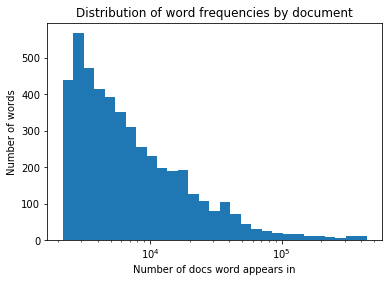

In [161]:
counts = train_vecs.getnnz(axis=0) # Any number of occurences in the same document is counted as 1, otherwise 0
min_count = counts.min()
max_count = counts.max()
logbins = np.geomspace(min_count, max_count, 30)
plt.hist(list(counts), bins=logbins)
plt.xscale('log')
plt.title('Distribution of word frequencies by document', size=12)
plt.xlabel('Number of docs word appears in')
plt.ylabel('Number of words')
plt.show

The great majority of the 12,000+ words of interest appear in 10,000 or fewer documents, the area to the left of the $10^4$ mark on the x-axis.

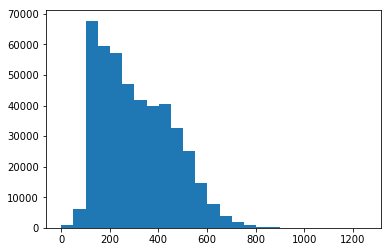

In [162]:
train_lengths = np.ravel(train_vecs.sum(axis=1))
plt.hist(train_lengths, bins=25)
plt.title('')
plt.show()

Relatively few, less than 10,000 or so, of the truncated articles have less than 100 or more than 700 words of interest. This combined with the previous graphic indicates that a simple bag-of-words approach could work reasonably well. This also means that limiting sentence length to 30 in the hierarchichal attention network will result in very little loss of content.

In [163]:
print(train_lengths.min(), train_lengths.max())

0 1253


In [164]:
train_nulls = [i for i, v in enumerate(train_lengths) if v == 0]
len(train_nulls)

104

Apparently, some of the processed articles have no words of interest. As such, these are indeterminate and should not be included in the data.

In [169]:
train_mask = np.ones(train_vecs.shape[0], dtype=bool)  # Remove null articles and their labels from the training set
train_mask[train_nulls] = False
train_vecs = train_vecs[train_mask]
y_train = y_train[train_mask]

test_lengths = np.ravel(test_vecs.sum(axis=1)) # Check test set for nulls
test_nulls = [i for i, v in enumerate(test_lengths) if v == 0]
len(test_nulls)

43

In [171]:
test_mask = np.ones(test_vecs.shape[0], dtype=bool)  
test_mask[test_nulls] = False
test_vecs = test_vecs[test_mask]
y_test = y_test[test_mask]

In [174]:
len(y_train)

447999

In [175]:
y_train.shape[0]

447999

Based on the article cited in the scikit-learn documentation (*Spam Filtering with Naive Bayes -- Which Naive Bayes?* by Vangelis Metsis, et al.), the multinomial Naive Bayes classifier with Boolean feature counts will be used. The paper is dated, published in 2006, but the algorithms have long been in use. A more sophisticted tf-idf approach also will be used with Naive Bayes and logistic regression classifiers in determining the best baseline model. 

In [194]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [179]:
train_bool = train_vecs.astype(bool)
test_bool = test_vecs.astype(bool)

In [196]:
MNB = MultinomialNB()

In [193]:
cross_validate(MNB, X=train_bool, y=y_train, cv=3, scoring=['f1', 'precision'], return_train_score=False)

{'fit_time': array([ 0.91121817,  0.849334  ,  0.82035708]),
 'score_time': array([ 0.4035511 ,  0.36255193,  0.36588812]),
 'test_f1': array([ 0.71967364,  0.71786256,  0.71978458]),
 'test_precision': array([ 0.85489755,  0.85615689,  0.85910678])}

The precision score is respectable, showing that relatively few unreliable articles are being classified as reliable. But the significantly lower f1 score shows that a high percentage of reliable articles are being misclassified as unreliable. Precision is more important in this case, but there is a lot of room for improvement.

In [195]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

In [198]:
cross_validate(MNB, X=tfidf.fit_transform(train_vecs), y=y_train, cv=3, scoring=['f1', 'precision'],
               return_train_score=False)

{'fit_time': array([ 0.95875287,  0.91884899,  0.91789913]),
 'score_time': array([ 0.20963907,  0.21117806,  0.20758605]),
 'test_f1': array([ 0.69853684,  0.69785068,  0.69949205]),
 'test_precision': array([ 0.86948196,  0.87118372,  0.87252017])}

For the multinomial Naive Bayes model using tf-idf vectorization, precision increased, but f1 decreased, hence no real improvement.

In [205]:
lr = LogisticRegression(solver='sag', max_iter=200)

In [206]:
cross_validate(lr, X=train_bool, y=y_train, cv=3, scoring=['f1', 'precision'], return_train_score=False)

/Users/vince/anaconda/envs/thinkful/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'fit_time': array([ 122.67330098,  120.9482069 ,  120.88513994]),
 'score_time': array([ 0.30912614,  0.30594206,  0.29783106]),
 'test_f1': array([ 0.82411227,  0.82054026,  0.82335354]),
 'test_precision': array([ 0.84377061,  0.8410203 ,  0.84362441])}

In [207]:
cross_validate(lr, X=tfidf.fit_transform(train_vecs), y=y_train, cv=3, scoring=['f1', 'precision'],
               return_train_score=False)

{'fit_time': array([ 12.77375269,  11.56666207,  12.09868622]),
 'score_time': array([ 0.13476419,  0.12797284,  0.13610077]),
 'test_f1': array([ 0.82807909,  0.82561246,  0.82715078]),
 'test_precision': array([ 0.84526649,  0.84287488,  0.84531283])}